In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.optim import lr_scheduler
import torch.utils.data
#import torchvision.transforms as transforms
import os

In [2]:
#Utils
def display3DObject(test_object, elev = None, azim = None):   
    print("Displaying the object")
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.view_init(elev=elev, azim=azim)

    ax.voxels(test_object, edgecolor='k')
    plt.show()
    
def addNoise(shape, noise=0.1):
    #print(shape)
    return Variable(torch.zeros(shape).normal_(0, noise).cuda())

In [3]:
import math
def logsumexp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log()
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0),
                                       dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        if isinstance(sum_exp, Number):
            return m + math.log(sum_exp)
        else:
            return m + torch.log(sum_exp)

In [4]:
def log_density(sample, mu, logsigma):
    normalization = Variable(torch.Tensor([np.log(2 * np.pi)]), requires_grad = False)
    c = normalization.type_as(sample.data)
    inv_sigma = torch.exp(-logsigma)
    tmp = (sample - mu) * inv_sigma
    return -0.5 * (tmp * tmp + 2 * logsigma + c)

In [5]:
# load images
images = np.load('chair_images.npy')
voxels = np.load('chair_voxels_filtered_0.npy')

# preprocessing
preprocessed_images = []
for subimages in images:
    preprocessed_subimages = np.array([(subimage - np.mean(subimage))/np.std(subimage) for subimage in subimages])
    preprocessed_images.append(preprocessed_subimages)
preprocessed_images = np.stack(preprocessed_images)

# reshuffle order
np.random.seed(42)
reseq = np.random.choice(len(images), len(images), replace=False)
preprocessed_images = np.array([preprocessed_images[i] for i in reseq])
voxels = np.array([voxels[i] for i in reseq])

train_images = preprocessed_images[:-130]
val_images = preprocessed_images[-130:-100]
test_images = preprocessed_images[-100:]
train_voxels = voxels[:-130]
val_voxels = voxels[-130:-100]
test_voxels = voxels[-100:]

In [62]:
# hyperparams
z_size = 15
batch_size = 256
Beta = 100.
Lamb = -49.

In [63]:
# loading


train_data = [train_voxels, train_images]
val_data = [val_voxels, val_images]
test_data = [test_voxels, test_images]

for _ in range(len(train_data)):
    train_data[_] = torch.from_numpy(train_data[_]).type(torch.FloatTensor)
    train_data[_] = train_data[_].cuda()
    
for _ in range(len(val_data)):
    val_data[_] = torch.from_numpy(val_data[_]).type(torch.FloatTensor)
    val_data[_] = val_data[_].cuda()
    
for _ in range(len(test_data)):
    test_data[_] = torch.from_numpy(test_data[_]).type(torch.FloatTensor)
    test_data[_] = test_data[_].cuda()

# train_data = [(train_data[0][i], train_data[1][i]) for i in range(len(train_data[0]))]
# test_data = [(test_data[0][i], test_data[1][i]) for i in range(len(test_data[0]))]


# train_loader = torch.utils.data.DataLoader(
#     train_data, batch_size=batch_size, shuffle=True, drop_last=True)

In [64]:
class VAE(nn.Module):
    def __init__(self, input_nc=1, z_size=200, ndf=25, cube_size=32):
        super(VAE, self).__init__()
        self.encoderLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.ReLU()
        )
        
        self.encoderLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*2),
            torch.nn.ReLU()
        )
        
        self.encoderLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*4),
            torch.nn.ReLU()
        )
        
        self.encoderLayer4 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer5 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=4, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer6 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.Tanh()
        )
        
        self.z_size = z_size
        self.cube_size = cube_size
        
        self.fc1 = nn.Linear(ndf*8, self.z_size)
        self.fc2 = nn.Linear(ndf*8, self.z_size)
        
        self.decoderLayer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.z_size, self.cube_size*4, kernel_size=4, stride=2, padding=(0,0,0)),
            torch.nn.BatchNorm3d(self.cube_size*4),
            torch.nn.ReLU()
        )
        
        self.decoderLayer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*4, self.cube_size*2, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*2),
            torch.nn.ReLU()
        )
        self.decoderLayer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*2, self.cube_size*1, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*1),
            torch.nn.ReLU()
        )

        self.decoderLayer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size, 1, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.Sigmoid()
        )
        
    def encoder(self, x): 
        out = self.encoderLayer1(x)
        out = self.encoderLayer2(out)
        out = self.encoderLayer3(out)
        out = self.encoderLayer4(out)
        out = self.encoderLayer5(out)
        out = self.encoderLayer6(out).view(-1, 200)
        return self.fc1(out), self.fc2(out)
    
    #source: https://github.com/bhpfelix/Variational-Autoencoder-PyTorch/blob/master/src/vanila_vae.py
    def reparametrize(self, mu, logsigma):
        std = logsigma.exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, x):
        out = self.decoderLayer1(x)
        out = self.decoderLayer2(out)
        out = self.decoderLayer3(out)
        out = self.decoderLayer4(out)
        return out
    
    def forward(self, x):
        mu, logsigma = self.encoder(x)
        latent = self.reparametrize(mu, logsigma)
        latent = latent.view(-1,self.z_size,1,1,1)#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
        
        object_3D = self.decoder(latent)
        return object_3D, mu, logsigma
    

In [65]:
vae = VAE(z_size=z_size)
vae.cuda()


VAE(
  (encoderLayer1): Sequential(
    (0): Conv2d(1, 25, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
  )
  (encoderLayer2): Sequential(
    (0): Conv2d(25, 50, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
  )
  (encoderLayer3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
  )
  (encoderLayer4): Sequential(
    (0): Conv2d(100, 200, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
  )
  (encoderLayer5): Sequential(
    (0): Conv2d(200, 200, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1))
    (1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
  )
  (encoderLayer6): Sequential(
    (0): Con

In [66]:
# hyperparameters
dataset_size= len(train_data)
learning_rate = 0.0025
# adam_beta = (0.5, 0.99)
solver = optim.Adam(vae.parameters(), lr=learning_rate)

In [67]:
def save_model(epoch):
    state_dicts = {'vae': vae.state_dict(), 'solver': solver.state_dict(), 'loss': losses_mean, \
                   'rec_loss': rec_losses_mean, 'mutinfo':mutinfos_mean, 'total_cor': total_cors_mean,\
                   'dim_kl': dim_kls_mean} 
    
    folder = 'tcvae_checkpoints_beta{}_zsize{}'.format(Beta, z_size)
    filename = 'epoch_{}.pt'.format(epoch)
    
    try:
        os.mkdir(folder)
    except:
        pass
    
    torch.save(state_dicts, os.path.join(folder, filename))


In [68]:
def load_model(path):
    state_dicts = torch.load(path)
    vae.load_state_dict(state_dicts['vae'])
    solver.load_state_dict(state_dicts['solver'])

In [69]:
def elbo(x, x_params, zs, mu, logsigma,  dataset_size, tcvae = True, beta=1., lamb = 0, include_mutinfo= True):
#     log p(x|z) + log p(z) - log q(z|x)
    batch_size = zs.size(0)
    z_dim = zs.size(1)
    prior_mu, prior_logsigma = Variable(torch.zeros(zs.size())).cuda(), Variable(torch.zeros(zs.size())).cuda()
    
    eps = 1e-8
    logpx = ((x_params+eps).log()*(x) + (1-x_params+eps).log()*(1-x)).sum(dim=-1).sum(-1).sum(-1)

    logpz = log_density(zs, prior_mu,prior_logsigma).view(batch_size, -1).sum(1)
    logqz_condx = log_density(zs, mu, logsigma).view(batch_size, -1).sum(1)

    elbo = logpx + logpz - logqz_condx

    if not tcvae:
        return elbo, elbo.detach(), logpx

    # compute log q(z) ~= log 1/(NM) sum_m=1^M q(z|x_m) = - log(MN) + logsumexp_m(q(z|x_m))

    _logqz = log_density(
        zs.view(batch_size, 1, z_dim),
        mu.unsqueeze(0), logsigma.unsqueeze(0)
    )

    # minibatch importance sampling
    logqz_prodmarginals = (logsumexp(_logqz, dim=1, keepdim=False) - math.log(batch_size * dataset_size)).sum(1)

    logqz = (logsumexp(_logqz.sum(2), dim=1, keepdim=False) - math.log(batch_size * dataset_size))
    mutinfo = logqz_condx - logqz
    total_cor = logqz - logqz_prodmarginals
    dim_kl =  logqz_prodmarginals - logpz
    if include_mutinfo:
        
        modified_elbo = logpx - \
            mutinfo - \
            beta * total_cor - \
            (1 - lamb) * dim_kl
    else:
        modified_elbo = logpx - \
            beta * total_cor - \
            (1 - lamb) * dim_kl

    return -modified_elbo, elbo.detach(), logpx, mutinfo, total_cor, dim_kl

In [70]:
#Training the system
num_epochs = 300

Losses = []
Rec_Losses = []
Mutinfos = []
Total_cors = []
Dim_kls = []

for epoch in range(num_epochs):
# for epoch in range(200,300):
    losses = []
    rec_losses = []
    mutinfos = []
    total_cors = []
    dim_kls = []
    for i in range(len(train_data[0])//batch_size):
        data_indices = np.random.choice(len(train_data[0]), batch_size)
        data_indices = torch.from_numpy(data_indices).cuda()
        data3d, data2d = train_data[0].index_select(0, data_indices), \
                            train_data[1].index_select(0, data_indices)
        
        
        var_3D_data = Variable(data3d.float(), requires_grad=False)
        
        indices = torch.from_numpy(np.random.randint(12, size = batch_size))
        indices = indices.unsqueeze(1).unsqueeze(2).expand(-1,128,128).unsqueeze(1).cuda()
        data2d = torch.gather(data2d, dim = 1, index=indices).squeeze()
        var_2D_data = Variable(data2d.float().unsqueeze(1), requires_grad = False)
        
        mu, logsigma = vae.encoder(var_2D_data)
        zs = vae.reparametrize(mu,logsigma)
        x_params = vae.decoder(zs.view(-1,z_size,1,1,1))
        
        x_params = x_params.squeeze()
        
        #loss 
        loss, elbo_term, logpx, mutinfo, total_cor, dim_kl = elbo(var_3D_data, x_params, zs, mu, logsigma,  \
                                                                  dataset_size, tcvae = True, beta=Beta, \
                                                                  lamb = Lamb, include_mutinfo= True)
        
        solver.zero_grad()
        loss.mean().backward()
        solver.step()
        
        losses.append(loss.mean().data.cpu().numpy())
        rec_losses.append(-logpx.mean().data.cpu().numpy())
        mutinfos.append(mutinfo.mean().data.cpu().numpy())
        total_cors.append(total_cor.mean().data.cpu().numpy())
        dim_kls.append(dim_kl.mean().data.cpu().numpy())
    
    losses_mean = np.mean(np.concatenate(losses))
    rec_losses_mean = np.mean(np.concatenate(rec_losses))
    mutinfos_mean = np.mean(np.concatenate(mutinfos))
    total_cors_mean = np.mean(np.concatenate(total_cors))
    dim_kls_mean = np.mean(np.concatenate(dim_kls))
    
    print("Epoch: ", epoch)
    
    print(' loss: ', losses_mean, 'rec_loss: ', rec_losses_mean, 'total cor: ', total_cors_mean)
    
    Losses.append(losses_mean)
    Rec_Losses.append(rec_losses_mean)
    Mutinfos.append(mutinfos_mean)
    Total_cors.append(total_cors_mean)
    Dim_kls.append(dim_kls_mean)
    
#     # validation
#     data3d, data2d = val_data
#     data2d = data2d[:,1].unsqueeze(1)
    
#     var_3D_data = Variable(data3d.cuda().float(), requires_grad=False)
#     var_2D_data = Variable(data2d.cuda().float(), requires_grad=False)
    
#     mu, logsigma = vae.encoder(var_2D_data)
#     zs = mu
#     x_params = vae.decoder(zs.view(-1,z_size,1,1,1))

#     x_params = x_params.squeeze()

#     #loss 
#     loss, elbo_term, logpx, mutinfo, total_cor, dim_kl = elbo(var_3D_data, x_params, zs, mu, logsigma,\
#                                                               dataset_size, tcvae = True, beta=1., \
#                                                               lamb = 0, include_mutinfo= True)
    
    
#     print(' valid loss: ', loss.mean().data.cpu().numpy(), 'valid rec_loss: ', -logpx.mean().data.cpu().numpy())
    
    # test model saving
    if (epoch+1)%5 == 0:
        save_model(epoch)
        folder = 'tcvae_checkpoints_beta{}_zsize{}'.format(Beta, z_size)
        filename = 'epoch_{}.pt'.format(epoch)
        path = os.path.join(folder, filename)
        load_model(path)

Epoch:  0
 loss:  19830.3 rec_loss:  19749.9 total cor:  9.73557
Epoch:  1
 loss:  12959.2 rec_loss:  12902.5 total cor:  9.68598
Epoch:  2
 loss:  9126.61 rec_loss:  9090.31 total cor:  9.6543
Epoch:  3
 loss:  7369.2 rec_loss:  7319.91 total cor:  9.64194
Epoch:  4
 loss:  6195.89 rec_loss:  6121.3 total cor:  9.72471
Epoch:  5
 loss:  5783.21 rec_loss:  5687.38 total cor:  9.75641
Epoch:  6
 loss:  5435.81 rec_loss:  5312.42 total cor:  9.8187
Epoch:  7
 loss:  5183.55 rec_loss:  5058.25 total cor:  9.77324
Epoch:  8
 loss:  5032.25 rec_loss:  4895.95 total cor:  9.78405
Epoch:  9
 loss:  4909.58 rec_loss:  4746.8 total cor:  9.89009
Epoch:  10
 loss:  4648.11 rec_loss:  4496.06 total cor:  9.82438
Epoch:  11
 loss:  4544.76 rec_loss:  4395.36 total cor:  9.81688
Epoch:  12
 loss:  4606.57 rec_loss:  4445.46 total cor:  9.85392
Epoch:  13
 loss:  4503.8 rec_loss:  4367.5 total cor:  9.76812
Epoch:  14
 loss:  4493.42 rec_loss:  4350.16 total cor:  9.7883
Epoch:  15
 loss:  4374.44 r

Epoch:  125
 loss:  3229.74 rec_loss:  3099.36 total cor:  9.674
Epoch:  126
 loss:  3315.82 rec_loss:  3180.27 total cor:  9.69859
Epoch:  127
 loss:  3184.86 rec_loss:  3052.01 total cor:  9.68413
Epoch:  128
 loss:  3184.68 rec_loss:  3056.3 total cor:  9.69065
Epoch:  129
 loss:  3175.01 rec_loss:  3046.55 total cor:  9.69141
Epoch:  130
 loss:  3177.26 rec_loss:  3041.67 total cor:  9.70349
Epoch:  131
 loss:  3174.65 rec_loss:  3045.87 total cor:  9.68849
Epoch:  132
 loss:  3226.73 rec_loss:  3093.86 total cor:  9.69331
Epoch:  133
 loss:  3244.89 rec_loss:  3111.01 total cor:  9.68087
Epoch:  134
 loss:  3167.76 rec_loss:  3026.61 total cor:  9.70187
Epoch:  135
 loss:  3215.96 rec_loss:  3086.79 total cor:  9.69188
Epoch:  136
 loss:  3227.89 rec_loss:  3097.43 total cor:  9.69769
Epoch:  137
 loss:  3266.87 rec_loss:  3135.33 total cor:  9.69839
Epoch:  138
 loss:  3200.18 rec_loss:  3070.98 total cor:  9.68364
Epoch:  139
 loss:  3293.51 rec_loss:  3159.65 total cor:  9.6903

Epoch:  248
 loss:  2618.24 rec_loss:  2463.87 total cor:  9.70905
Epoch:  249
 loss:  2543.41 rec_loss:  2390.37 total cor:  9.70807
Epoch:  250
 loss:  2625.4 rec_loss:  2465.59 total cor:  9.70694
Epoch:  251
 loss:  2577.17 rec_loss:  2420.88 total cor:  9.70291
Epoch:  252
 loss:  2626.09 rec_loss:  2471.29 total cor:  9.70209
Epoch:  253
 loss:  2570.88 rec_loss:  2413.89 total cor:  9.70141
Epoch:  254
 loss:  2595.96 rec_loss:  2438.53 total cor:  9.72294
Epoch:  255
 loss:  2571.48 rec_loss:  2409.7 total cor:  9.72871
Epoch:  256
 loss:  2574.07 rec_loss:  2416.04 total cor:  9.7296
Epoch:  257
 loss:  2572.76 rec_loss:  2418.25 total cor:  9.72289
Epoch:  258
 loss:  2605.25 rec_loss:  2450.91 total cor:  9.71304
Epoch:  259
 loss:  2572.11 rec_loss:  2416.08 total cor:  9.7118
Epoch:  260
 loss:  2564.47 rec_loss:  2407.53 total cor:  9.70096
Epoch:  261
 loss:  2554.99 rec_loss:  2399.51 total cor:  9.72143
Epoch:  262
 loss:  2602.72 rec_loss:  2448.95 total cor:  9.7061


[-17.665981,
 -18.421173,
 -18.36042,
 -18.40749,
 -17.917566,
 -17.658854,
 -17.437351,
 -17.641788,
 -17.457327,
 -16.891411,
 -17.153358,
 -17.119101,
 -17.362532,
 -17.535328,
 -17.562862,
 -17.389744,
 -17.261478,
 -17.508947,
 -17.266844,
 -17.355145,
 -17.472904,
 -17.579456,
 -17.289583,
 -17.561495,
 -17.435291,
 -17.49527,
 -17.49379,
 -17.551533,
 -17.562225,
 -17.45694,
 -17.431721,
 -17.39579,
 -17.424265,
 -17.316086,
 -17.210665,
 -17.402765,
 -17.383757,
 -17.330435,
 -17.254366,
 -17.34812,
 -17.123833,
 -17.132931,
 -17.134815,
 -17.121832,
 -17.16847,
 -17.186319,
 -17.158384,
 -16.946915,
 -17.123287,
 -17.203489,
 -17.097889,
 -17.177891,
 -17.102974,
 -17.130741,
 -17.255157,
 -17.183632,
 -17.021544,
 -17.08186,
 -17.034563,
 -17.079775,
 -17.121359,
 -17.24358,
 -17.241144,
 -17.179409,
 -16.951221,
 -17.007961,
 -16.975899,
 -17.249842,
 -17.157576,
 -17.183247,
 -17.092554,
 -17.246548,
 -17.185354,
 -17.153484,
 -17.074244,
 -17.229565,
 -17.178963,
 -17.0873

In [71]:
# test: single sample vs multiview greeedy vs multiview probabilistic
for epoch in range(199,300, 5):
    folder = 'tcvae_checkpoints_beta{}_zsize{}'.format(Beta, z_size)
    filename = 'epoch_{}.pt'.format(epoch)
    path = os.path.join(folder, filename)
    load_model(path)
    
    avg_singleview_rec_losses = []
    best_singleview_rec_losses = []
    multiview_greedy_rec_losses = []
    sigma_list = []
    greedy_sigma_list = []

    for i in range(len(test_data)):
        data3d, data2d = test_data[0][i], test_data[1][i]
        data2d = data2d.unsqueeze(1)

        var_3D_data = Variable(data3d.cuda().float(), requires_grad=False).unsqueeze(0)
        var_2D_data = Variable(data2d.cuda().float(), requires_grad=False)
        mu, logsigma = vae.encoder(var_2D_data)

        # single view reconstructions
        zs = mu
        x_params = vae.decoder(zs.view(-1,z_size,1,1,1))
        x_params = x_params.squeeze()
        
        
        loss, elbo_term, logpx, mutinfo, total_cor, dim_kl = elbo(var_3D_data.expand(data2d.size(0), -1, -1, -1), \
                                                                  x_params, \
                                                                  zs, mu, logsigma,  \
                                                                  dataset_size, tcvae = True, beta=Beta, \
                                                                  lamb = 0, include_mutinfo= True)
        
        avg_rec_loss = -logpx.mean().data.cpu().numpy()[0]
        best_rec_loss = -np.max(logpx.data.cpu().numpy())
    
        sigma_mean = logsigma.exp().mean().data.cpu().numpy()
        avg_singleview_rec_losses.append(avg_rec_loss)
        best_singleview_rec_losses.append(best_rec_loss)
        sigma_list.append(sigma_mean)

        # multiview greedy
        greedy_indices = torch.min(logsigma, dim=0)[1]
        mu = mu.gather(0, greedy_indices.view(1,-1))
        logsigma = logsigma.gather(0, greedy_indices.view(1,-1))
        zs = mu.view(-1,vae.z_size,1,1,1)#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
        x_params = vae.decoder(zs)
        x_params = x_params.squeeze().unsqueeze(0)
        
        loss, elbo_term, logpx, mutinfo, total_cor, dim_kl = elbo(var_3D_data.expand(data2d.size(0), -1, -1, -1), \
                                                          x_params, \
                                                          zs, mu, logsigma,  \
                                                          dataset_size, tcvae = True, beta=Beta, \
                                                          lamb = 0, include_mutinfo= True)
        
        
        greedy_rec_loss = -logpx.data.cpu().numpy()[0]
        greedy_sigma = logsigma.exp().mean().data.cpu().numpy()
        
        multiview_greedy_rec_losses.append(greedy_rec_loss)
        greedy_sigma_list.append(greedy_sigma)

    sigma_list = np.stack(sigma_list)
    greedy_sigma_list = np.stack(greedy_sigma_list)

    print('epoch', epoch)
    print('single view sigma', np.mean(sigma_list))
    print('single view average', sum(avg_singleview_rec_losses)/len(avg_singleview_rec_losses))
    print('single view best', sum(best_singleview_rec_losses)/len(best_singleview_rec_losses))
    print('multiview greedy sigma', np.mean(greedy_sigma_list))
    print('multiview greedy', sum(multiview_greedy_rec_losses)/len(multiview_greedy_rec_losses))

epoch 199
single view sigma 0.641869
single view average 10916.9885254
single view best 4760.69836426
multiview greedy sigma 0.527972
multiview greedy 5849.06237793
epoch 204
single view sigma 0.62716
single view average 9932.92163086
single view best 4856.79382324
multiview greedy sigma 0.53282
multiview greedy 5554.53076172
epoch 209
single view sigma 0.60558
single view average 9465.99438477
single view best 4618.98046875
multiview greedy sigma 0.519116
multiview greedy 5080.15820312
epoch 214
single view sigma 0.615105
single view average 9729.90698242
single view best 4659.34667969
multiview greedy sigma 0.532459
multiview greedy 5091.1595459
epoch 219
single view sigma 0.611969
single view average 11661.0339355
single view best 4592.93945312
multiview greedy sigma 0.528448
multiview greedy 6114.52612305
epoch 224
single view sigma 0.600918
single view average 8421.91821289
single view best 4196.5213623
multiview greedy sigma 0.519959
multiview greedy 3963.1463623
epoch 229
single

In [72]:
folder = 'tcvae_checkpoints_beta{}_zsize{}'.format(Beta, z_size)
filename = 'epoch_{}.pt'.format(224)
path = os.path.join(folder, filename)
load_model(path)

original object
Displaying the object


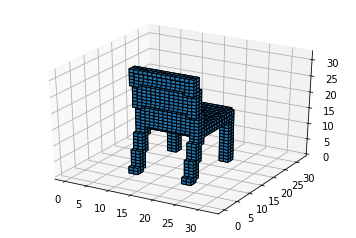

view 0
sigma : 0.628637433052063
rec loss : 2372.701416015625
Displaying the object


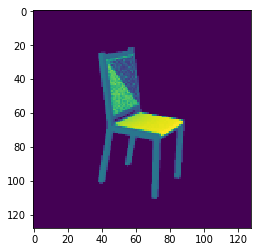

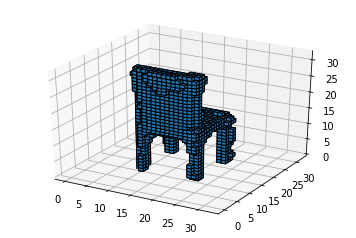

view 1
sigma : 0.6344773769378662
rec loss : 2309.472412109375
Displaying the object


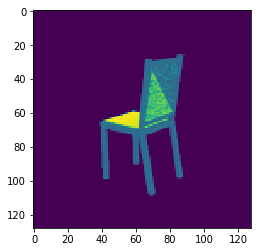

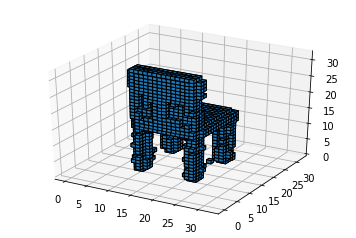

view 2
sigma : 0.6130443215370178
rec loss : 2950.458740234375
Displaying the object


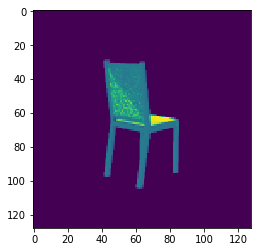

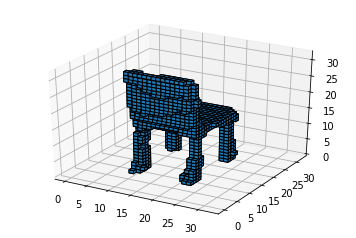

view 3
sigma : 0.6326646208763123
rec loss : 1863.5821533203125
Displaying the object


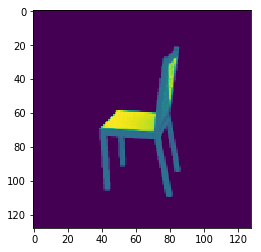

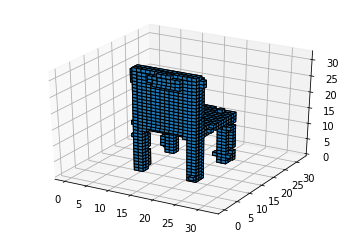

view 4
sigma : 0.6184651255607605
rec loss : 6822.18017578125
Displaying the object


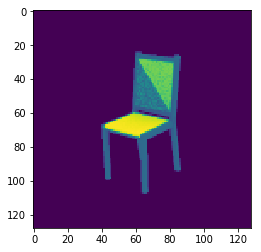

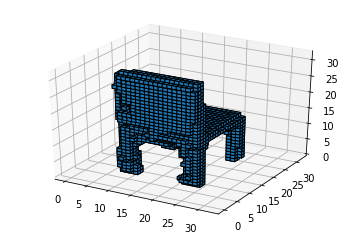

view 5
sigma : 0.6221569180488586
rec loss : 2982.8583984375
Displaying the object


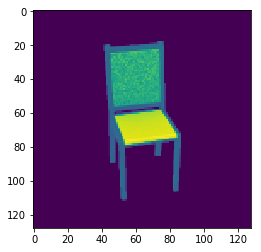

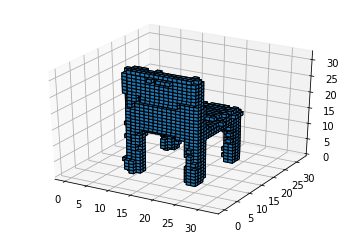

view 6
sigma : 0.6282917261123657
rec loss : 4213.90625
Displaying the object


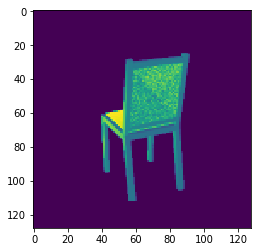

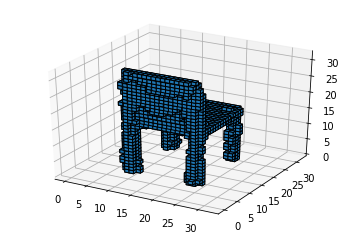

view 7
sigma : 0.6198632121086121
rec loss : 2836.888671875
Displaying the object


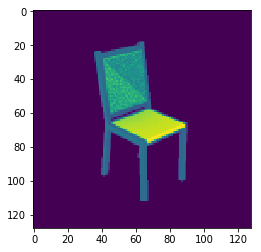

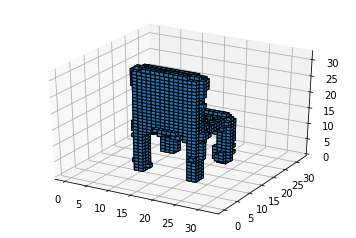

view 8
sigma : 0.6269615888595581
rec loss : 2419.829833984375
Displaying the object


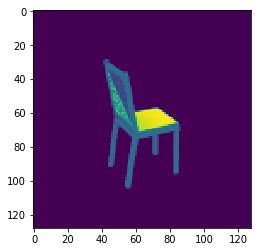

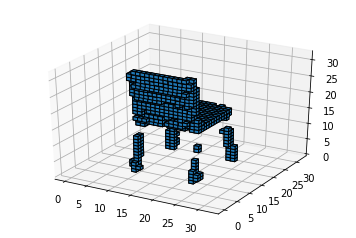

view 9
sigma : 0.6427353620529175
rec loss : 3486.580078125
Displaying the object


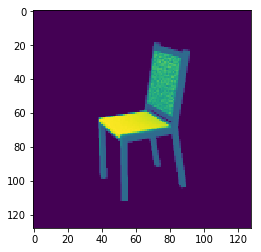

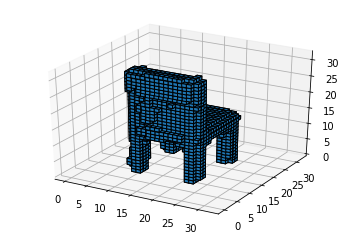

view 10
sigma : 0.59626704454422
rec loss : 3437.52294921875
Displaying the object


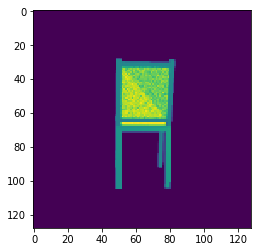

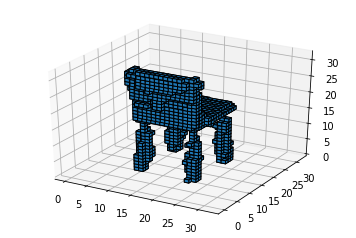

view 11
sigma : 0.6144710779190063
rec loss : 2026.981201171875
Displaying the object


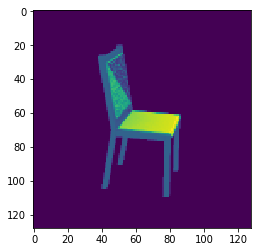

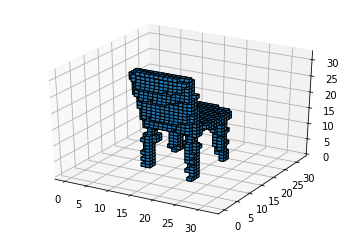

greedy
sigma : [ 0.54160571]
rec loss : 2775.834228515625
Displaying the object


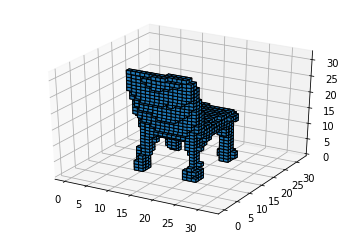

In [77]:
# reconstruct test objects
i = 25
data3d, data2d = test_data[0][i], test_data[1][i]

var_3D_data = Variable(data3d.cuda().float(), requires_grad=False).unsqueeze(0)
var_2D_data = Variable(data2d.cuda().float(), requires_grad=False).unsqueeze(1)
mu, logsigma = vae.encoder(var_2D_data)

# single view reconstructions
zs = mu
x_params = vae.decoder(zs.view(-1,z_size,1,1,1))
x_params = x_params.squeeze()

loss, elbo_term, logpx, mutinfo, total_cor, dim_kl = elbo(var_3D_data.expand(data2d.size(0), -1, -1, -1), \
                                                              x_params, \
                                                              zs, mu, logsigma,  \
                                                              dataset_size, tcvae = True, beta=1., \
                                                              lamb = 0, include_mutinfo= True)

objects = x_params.data.cpu().numpy()
sigma_mean = logsigma.exp().mean(1).data.cpu().numpy()
rec_loss = -logpx.data.cpu().numpy()

print('original object')

display3DObject(data3d.cpu().numpy())

for j in range(data2d.size(0)):
    print('view {}'.format(j))
    print('sigma : {}'.format(sigma_mean[j]))
    print('rec loss : {}'.format(rec_loss[j]))
    plt.imshow(data2d.cpu().numpy()[j])
    display3DObject(objects[j]>0.5)
               

greedy_indices = torch.min(logsigma, dim=0)[1]
mu = mu.gather(0, greedy_indices.view(1,-1))
logsigma = logsigma.gather(0, greedy_indices.view(1,-1))
zs = mu#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
x_params = vae.decoder(zs.view(-1,vae.z_size,1,1,1))
x_params = x_params.squeeze().unsqueeze(0)

loss, elbo_term, logpx, mutinfo, total_cor, dim_kl = elbo(var_3D_data.expand(data2d.size(0), -1, -1, -1), \
                                                  x_params, \
                                                  zs, mu, logsigma,  \
                                                  dataset_size, tcvae = True, beta=1., \
                                                  lamb = 0, include_mutinfo= True)


greedy_rec_loss = -logpx.data.cpu().numpy()[0]
greedy_sigma = logsigma.exp().mean().data.cpu().numpy()

print('greedy')
print('sigma : {}'.format(greedy_sigma))
print('rec loss : {}'.format(greedy_rec_loss))
display3DObject(x_params.squeeze().data.cpu().numpy()>0.5)
               
               


Displaying the object


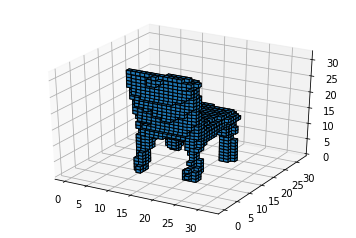

Displaying the object


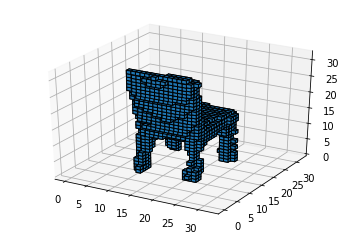

Displaying the object


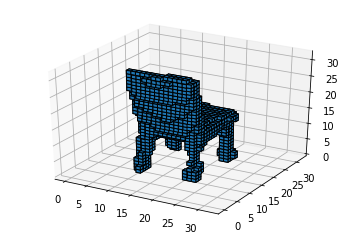

Displaying the object


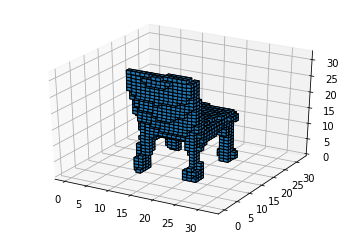

Displaying the object


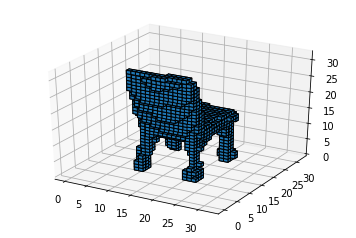

Displaying the object


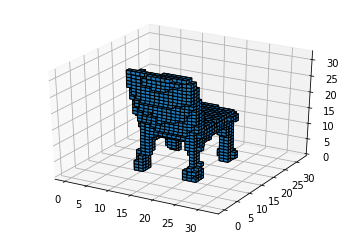

Displaying the object


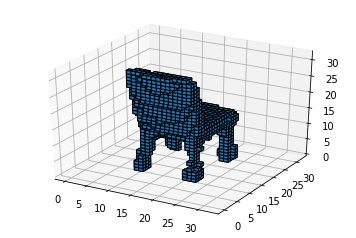

Displaying the object


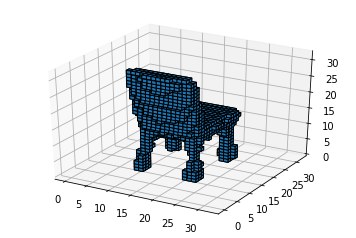

Displaying the object


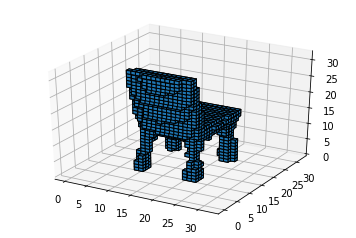

In [81]:
static = zs.data.cpu().numpy()
i =5
for val in [-2., -1.5, -1, -0.5, 0, 0.5, 1., 1.5, 2]:
    latent = static.copy()
    latent[0][i] = val
    latent_var = Variable(torch.from_numpy(latent).cuda())
    x_params = vae.decoder(latent_var.view(-1,vae.z_size,1,1,1))
    x_params = x_params.squeeze().unsqueeze(0)
    display3DObject(x_params.squeeze().data.cpu().numpy()>0.5)

Displaying the object


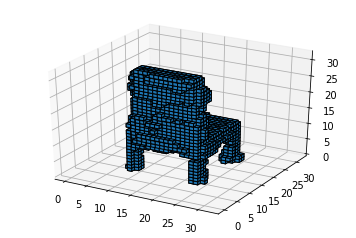

Displaying the object


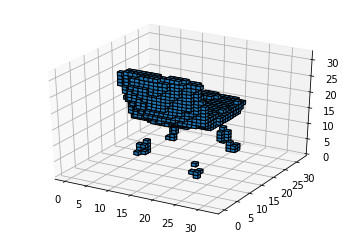

Displaying the object


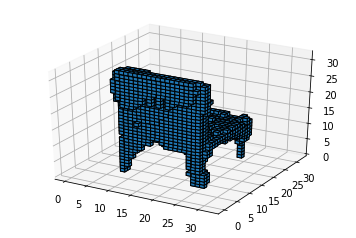

Displaying the object


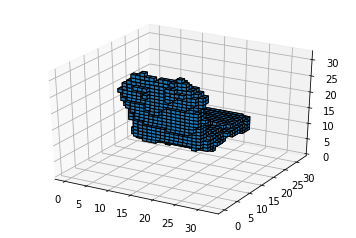

Displaying the object


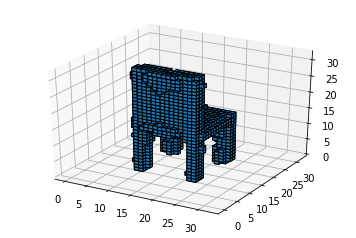

Displaying the object


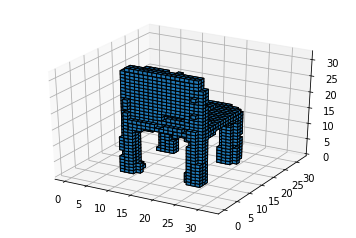

Displaying the object


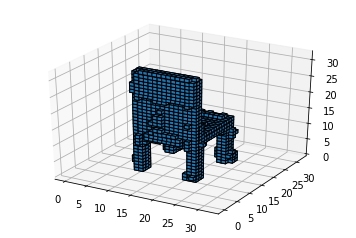

Displaying the object


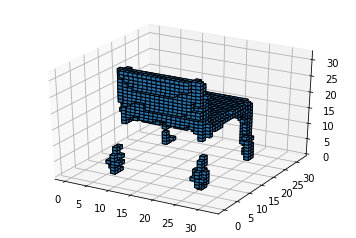

Displaying the object


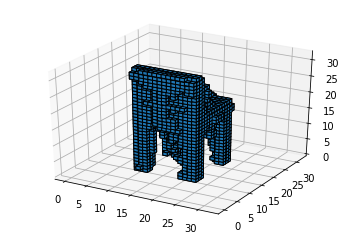

Displaying the object


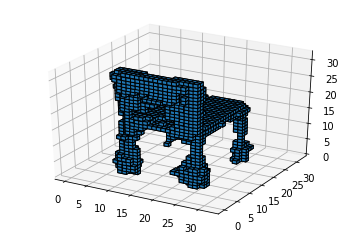

In [83]:
for i in range(10):
    latent = torch.cuda.FloatTensor(z_size).normal_()
    latent_var = Variable(latent)
    x_params = vae.decoder(latent_var.view(-1,vae.z_size,1,1,1))
    x_params = x_params.squeeze().unsqueeze(0)
    display3DObject(x_params.squeeze().data.cpu().numpy()>0.5)